In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import requests
import tqdm
from time import sleep
import time
from PIL import Image
from io import BytesIO
from adjustText import adjust_text
from scipy.interpolate import interp1d

In [2]:
from nba_api.stats.static.players import find_players_by_full_name
from nba_api.stats.static.teams import find_teams_by_full_name, get_teams, find_team_name_by_id
from nba_api.stats.endpoints.playbyplayv2 import PlayByPlayV2
from nba_api.stats.endpoints.leaguegamefinder import LeagueGameFinder
from nba_api.stats.endpoints.shotchartdetail import ShotChartDetail

In [3]:
celtics_id = find_teams_by_full_name("Boston Celtics")[0]['id']

In [4]:
raptors_id = find_teams_by_full_name("Toronto Raptors")[0]['id']

In [16]:
bball_gray = '#312f30'
bball_white = '#dddee0'
bball_orange = '#f87c24'
bball_light_orange = '#fbaf7b'

### Tracking efficiency

In [5]:
from nba_api.stats.endpoints.leaguedashptstats import LeagueDashPtStats

tracking_stats = LeagueDashPtStats(pt_measure_type='Efficiency', season_type_all_star="Playoffs", per_mode_simple='PerGame')

teams_tracking_df = tracking_stats.get_data_frames()[0]

In [6]:
teams_tracking_df

,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GP,W,L,MIN,POINTS,DRIVE_PTS,DRIVE_FG_PCT,...,CATCH_SHOOT_FG_PCT,PULL_UP_PTS,PULL_UP_FG_PCT,PAINT_TOUCH_PTS,PAINT_TOUCH_FG_PCT,POST_TOUCH_PTS,POST_TOUCH_FG_PCT,ELBOW_TOUCH_PTS,ELBOW_TOUCH_FG_PCT,EFF_FG_PCT
0,1610612738,BOS,Boston Celtics,4,4,0,240.0,112.3,26.8,0.529,...,0.386,31.0,0.382,14.0,0.551,2.5,0.500,9.0,0.714,0.523
1,1610612751,BKN,Brooklyn Nets,4,0,4,240.0,105.8,21.5,0.395,...,0.373,17.0,0.312,12.5,0.611,1.3,1.000,3.8,0.600,0.482
2,1610612742,DAL,Dallas Mavericks,5,2,3,245.0,121.0,36.0,0.519,...,0.395,30.2,0.418,15.2,0.660,4.4,0.462,1.8,0.333,0.562
3,1610612743,DEN,Denver Nuggets,5,2,3,245.0,114.2,23.2,0.500,...,0.400,29.2,0.508,12.2,0.509,7.4,0.538,8.2,0.692,0.559
4,1610612745,HOU,Houston Rockets,4,2,2,246.3,113.8,32.0,0.532,...,0.371,21.5,0.352,7.5,0.609,1.0,0.333,2.8,0.833,0.547
5,1610612754,IND,Indiana Pacers,4,0,4,240.0,100.8,27.3,0.444,...,0.434,18.0,0.326,12.5,0.639,0.5,0.250,3.0,0.455,0.530
6,1610612746,LAC,LA Clippers,5,3,2,245.0,129.8,38.6,0.610,...,0.438,31.2,0.439,20.0,0.644,7.2,0.591,2.4,0.500,0.586
7,1610612747,LAL,Los Angeles Lakers,4,3,1,240.0,113.8,18.5,0.455,...,0.367,16.0,0.351,23.8,0.688,3.8,0.500,4.5,0.667,0.534
8,1610612748,MIA,Miami Heat,4,4,0,240.0,111.3,23.8,0.468,...,0.450,14.0,0.347,17.0,0.628,4.3,0.467,8.5,0.400,0.545
9,1610612749,MIL,Milwaukee Bucks,4,3,1,240.0,115.8,25.3,0.581,...,0.437,23.0,0.376,16.8,0.690,1.3,0.286,6.3,0.556,0.578


In [7]:
celtics_playoffs_df = teams_tracking_df.loc[teams_tracking_df.TEAM_ID == celtics_id]
raptors_playoffs_df = teams_tracking_df.loc[teams_tracking_df.TEAM_ID == raptors_id]

In [8]:
from nba_api.stats.endpoints.leaguedashptstats import LeagueDashPtStats

tracking_stats = LeagueDashPtStats(pt_measure_type='Efficiency', per_mode_simple='PerGame')

teams_tracking_df = tracking_stats.get_data_frames()[0]

celtics_regular_df = teams_tracking_df.loc[teams_tracking_df.TEAM_ID == celtics_id]
raptors_regular_df = teams_tracking_df.loc[teams_tracking_df.TEAM_ID == raptors_id]

In [12]:
interesting_columns = ['DRIVE_PTS',
       'CATCH_SHOOT_PTS', 'PULL_UP_PTS', 'PAINT_TOUCH_PTS',
       'POST_TOUCH_PTS', 'ELBOW_TOUCH_PTS']

raptors_data = raptors_playoffs_df.loc[:, interesting_columns].iloc[0]
celtics_data = celtics_playoffs_df.loc[:, interesting_columns].iloc[0]

In [18]:
plt.style.use('fivethirtyeight')

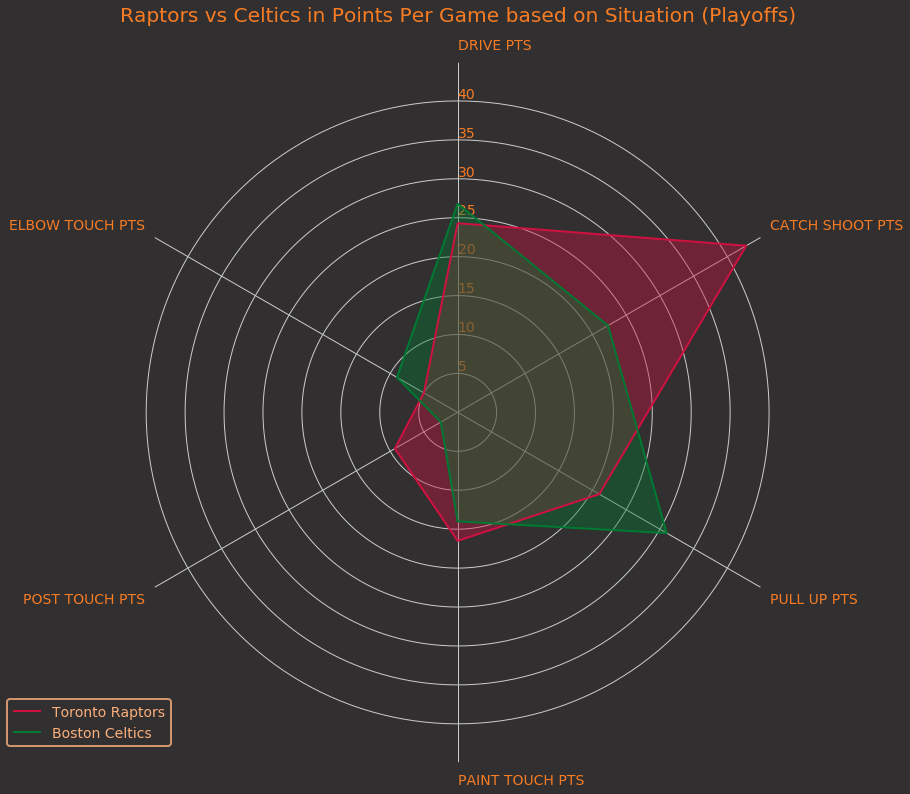

In [19]:
import matplotlib.pyplot as plt
import pandas as pd
from math import pi

# number of variable
categories=list(raptors_data.tolist())
N = len(categories)
 
# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
 
fig = plt.figure(figsize=(12, 12))
# Initialise the spider plot
ax = plt.subplot(111, polar=True)
 
# If you want the first axis to be on top:
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
 
# Draw one axe per variable + add labels labels yet
plt.xticks(angles[:-1], [item.replace("_", " ") for item in raptors_data.index.tolist()])
for label,i in zip(ax.get_xticklabels(),range(0,len(angles))):

    angle_rad=angles[i]
    if angle_rad <= pi/2:
        ha= 'left'
        va= "bottom"
        angle_text=angle_rad*(-180/pi)+90
    elif pi/2 < angle_rad <= pi:
        ha= 'left'
        va= "top"
        angle_text=angle_rad*(-180/pi)+90
    elif pi < angle_rad <= (3*pi/2):
        ha= 'right'
        va= "top"  
        angle_text=angle_rad*(-180/pi)-90
    else:
        ha= 'right'
        va= "bottom"
        angle_text=angle_rad*(-180/pi)-90
    label.set_rotation(angle_text)
    label.set_verticalalignment(va)
    label.set_horizontalalignment(ha)


# Draw ylabels
ax.set_rlabel_position(0)
#items = [item / 10 for item in range(0, 55, 10)]
#plt.yticks(items, map(str, items), size=12)
#ax.spines['polar'].set_color('#cbcbcb')
#ax.spines['polar'].set_linewidth('1')
max_val = max(raptors_data.max(), celtics_data.max())
plt.ylim(0, max_val + 0.05 * max_val)
ax.spines['polar'].set_visible(False)

plt.title("Raptors vs Celtics in Points Per Game based on Situation (Playoffs)", color=bball_orange)
values=raptors_data.tolist()
values += values[:1]
ax.plot(angles, values, linewidth=2, linestyle='solid', label="Toronto Raptors", color='#CE1141')
ax.fill(angles, values, '#CE1141', alpha=0.4)

values=celtics_data.tolist()
values += values[:1]
ax.plot(angles, values, linewidth=2, linestyle='solid', label="Boston Celtics", color='#007A33')
ax.fill(angles, values, '#007A33', alpha=0.4)
legend = plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1), fontsize=14)

ticks = ax.get_xticklabels()
for tick in ticks:
    tick.set_color(bball_orange)
ticks = ax.get_yticklabels()
for tick in ticks:
    tick.set_color(bball_orange)
#ax.set_yticklabels(f"{item}%" for item in range(5, 35, 5))
    
frame = legend.get_frame()
frame.set_facecolor(bball_gray)
frame.set_linewidth(2)
frame.set_edgecolor(bball_light_orange)
for text in legend.get_texts():
    text.set_color(bball_light_orange)

ax.set_frame_on(False)
ax.set_facecolor(bball_gray)
fig.set_facecolor(bball_gray)

#### Regular

In [20]:
interesting_columns = ['DRIVE_PTS',
       'CATCH_SHOOT_PTS', 'PULL_UP_PTS', 'PAINT_TOUCH_PTS',
       'POST_TOUCH_PTS', 'ELBOW_TOUCH_PTS']

raptors_data = raptors_regular_df.loc[:, interesting_columns].iloc[0]
celtics_data = celtics_regular_df.loc[:, interesting_columns].iloc[0]


In [23]:
import matplotlib.pyplot as plt
import pandas as pd
from math import pi

def plot_radar(first_data, second_data, title, first_label, second_label, first_color, second_color):
    # number of variable
    categories=list(first_data.tolist())
    N = len(categories)

    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    fig = plt.figure(figsize=(12, 12))
    # Initialise the spider plot
    ax = plt.subplot(111, polar=True)

    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], [item.replace("_", " ") for item in first_data.index.tolist()])
    for label,i in zip(ax.get_xticklabels(),range(0,len(angles))):

        angle_rad=angles[i]
        if angle_rad <= pi/2:
            ha= 'left'
            va= "bottom"
            angle_text=angle_rad*(-180/pi)+90
        elif pi/2 < angle_rad <= pi:
            ha= 'left'
            va= "top"
            angle_text=angle_rad*(-180/pi)+90
        elif pi < angle_rad <= (3*pi/2):
            ha= 'right'
            va= "top"  
            angle_text=angle_rad*(-180/pi)-90
        else:
            ha= 'right'
            va= "bottom"
            angle_text=angle_rad*(-180/pi)-90
        label.set_rotation(angle_text)
        label.set_verticalalignment(va)
        label.set_horizontalalignment(ha)


    # Draw ylabels
    ax.set_rlabel_position(0)
    #items = [item / 10 for item in range(0, 55, 10)]
    #plt.yticks(items, map(str, items), size=12)
    #ax.spines['polar'].set_color('#cbcbcb')
    #ax.spines['polar'].set_linewidth('1')
    max_val = max(first_data.max(), second_data.max())
    plt.ylim(0, max_val + 0.05 * max_val)
    ax.spines['polar'].set_visible(False)

    plt.title(title, color=bball_orange)
    values=first_data.tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=2, linestyle='solid', label=first_label, color=first_color)
    ax.fill(angles, values, first_color, alpha=0.4)

    values=second_data.tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=2, linestyle='solid', label=second_label, color=second_color)
    ax.fill(angles, values, second_color, alpha=0.4)
    legend = plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1), fontsize=14)

    ticks = ax.get_xticklabels()
    for tick in ticks:
        tick.set_color(bball_orange)
    ticks = ax.get_yticklabels()
    for tick in ticks:
        tick.set_color(bball_orange)
    #ax.set_yticklabels(f"{item}%" for item in range(5, 35, 5))

    frame = legend.get_frame()
    frame.set_facecolor(bball_gray)
    frame.set_linewidth(2)
    frame.set_edgecolor(bball_light_orange)
    for text in legend.get_texts():
        text.set_color(bball_light_orange)

    ax.set_frame_on(False)
    ax.set_facecolor(bball_gray)
    fig.set_facecolor(bball_gray)

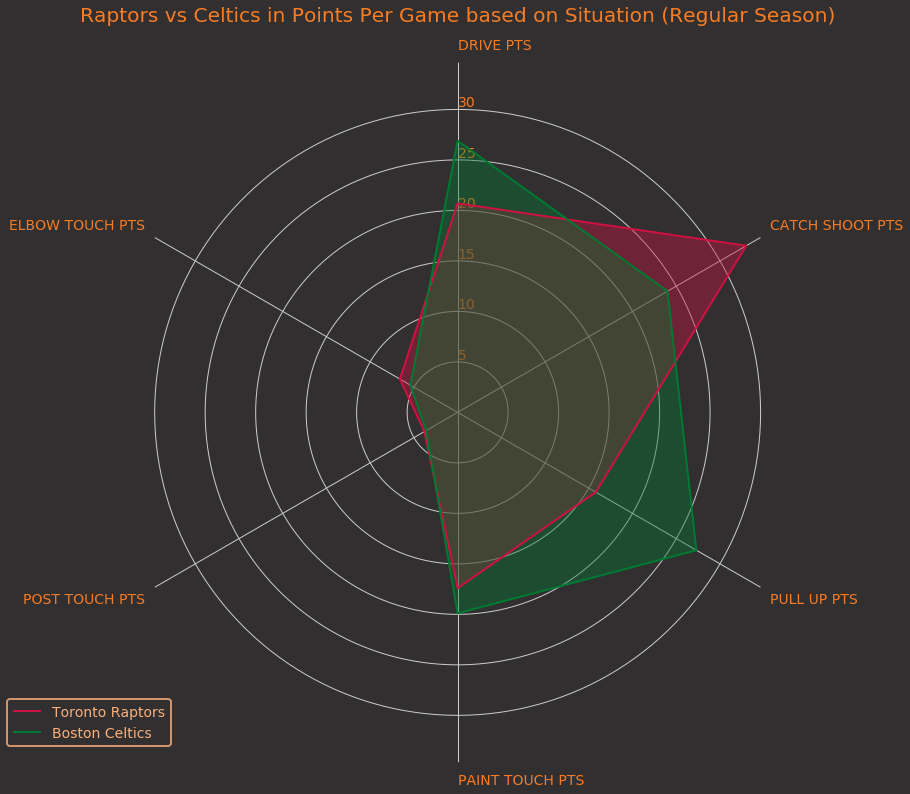

In [24]:
plot_radar(
    first_data=raptors_data,
    first_label='Toronto Raptors',
    first_color='#CE1141',
    second_data=celtics_data,
    second_label='Boston Celtics',
    second_color='#007A33',
    title='Raptors vs Celtics in Points Per Game based on Situation (Regular Season)'
)

### Regular vs Playoffs per Team

#### Raptors

In [26]:
raptors_regular_data = raptors_regular_df.loc[:, interesting_columns].iloc[0]
raptors_playoff_data = raptors_playoffs_df.loc[:, interesting_columns].iloc[0]

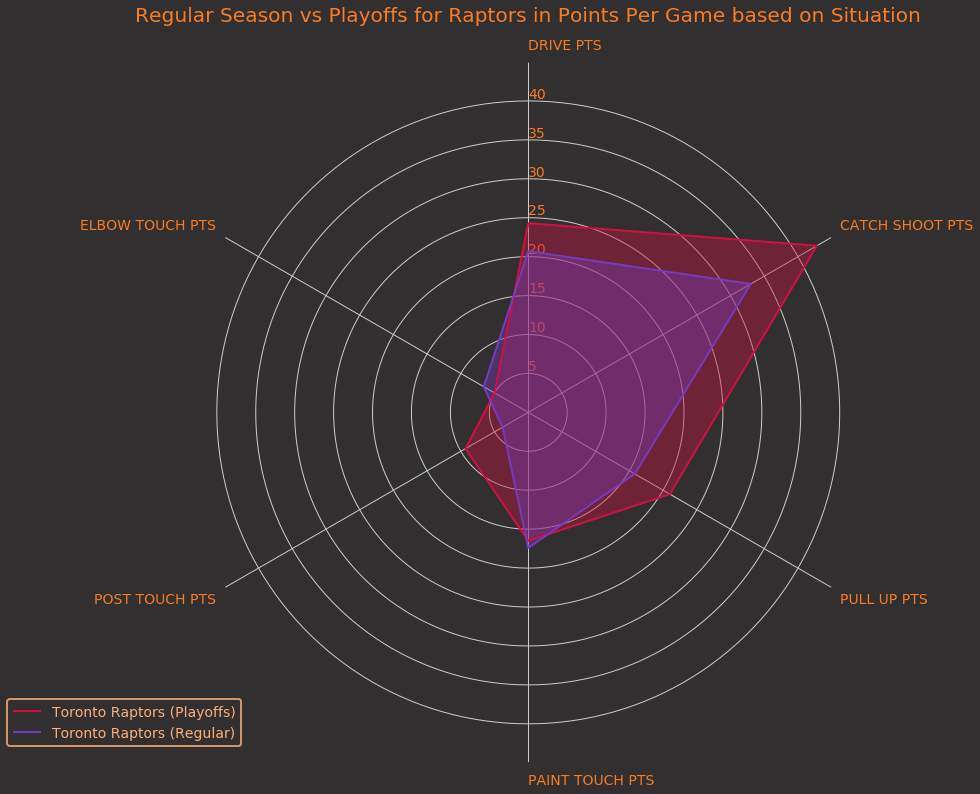

In [29]:
plot_radar(
    first_data=raptors_playoff_data,
    first_label='Toronto Raptors (Playoffs)',
    first_color='#CE1141',
    second_data=raptors_regular_data,
    second_label='Toronto Raptors (Regular)',
    second_color='#753BBD',
    title='Regular Season vs Playoffs for Raptors in Points Per Game based on Situation'
)

#### Celtics

In [30]:
celtics_regular_data = celtics_regular_df.loc[:, interesting_columns].iloc[0]
celtics_playoff_data = celtics_playoffs_df.loc[:, interesting_columns].iloc[0]

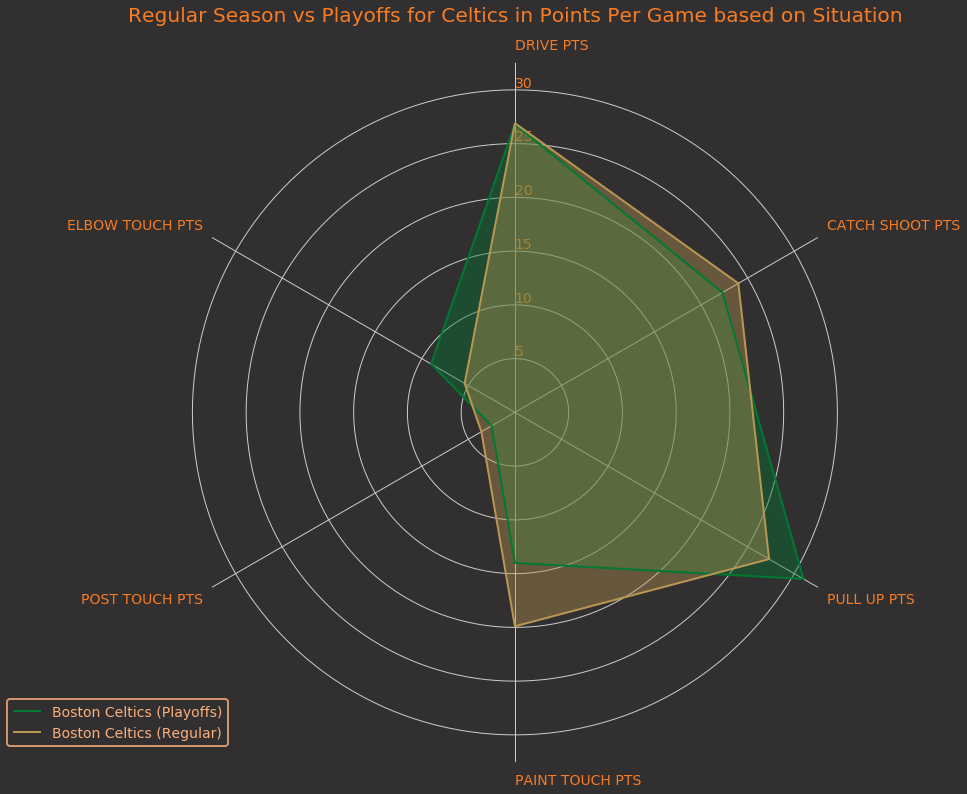

In [32]:
plot_radar(
    first_data=celtics_playoff_data,
    first_label='Boston Celtics (Playoffs)',
    first_color='#007A33',
    second_data=celtics_regular_data,
    second_label='Boston Celtics (Regular)',
    second_color='#BA9653',
    title='Regular Season vs Playoffs for Celtics in Points Per Game based on Situation'
)

### Play Type

In [33]:
from nba_api.stats.endpoints.synergyplaytypes import SynergyPlayTypes

In [34]:
play_types = [
    "Postup",
    "Spotup",
    "PRBallHandler",
    "PRRollman",
    "Transition",
    "Cut",
    "OffScreen",
    "OffRebound",
    "Handoff",
    "Isolation",
]


In [36]:
play_type_dict = {}
for play in play_types:
    synergy = SynergyPlayTypes(player_or_team_abbreviation="T", play_type_nullable=play, type_grouping_nullable="offensive", per_mode_simple="PerGame", season='2019-20', season_type_all_star='Playoffs')
    synergy_df = synergy.get_data_frames()[0]
    play_type_dict[play] = synergy_df
    time.sleep(1)

In [38]:
raptors_play_type_playoffs = []
celtics_play_type_playoffs = []

for play in play_type_dict:
    cur_df = play_type_dict[play]
    raptors_play_type_playoffs.append(cur_df.loc[cur_df.TEAM_ID == raptors_id])
    celtics_play_type_playoffs.append(cur_df.loc[cur_df.TEAM_ID == celtics_id])

In [61]:
raptors_pt_df = pd.concat(raptors_play_type_playoffs).loc[:, ['PLAY_TYPE', 'PTS']].pivot_table(index='PLAY_TYPE', values='PTS').transpose().iloc[0]
celtics_pt_df = pd.concat(celtics_play_type_playoffs).loc[:, ['PLAY_TYPE', 'PTS']].pivot_table(index='PLAY_TYPE', values='PTS').transpose().iloc[0]

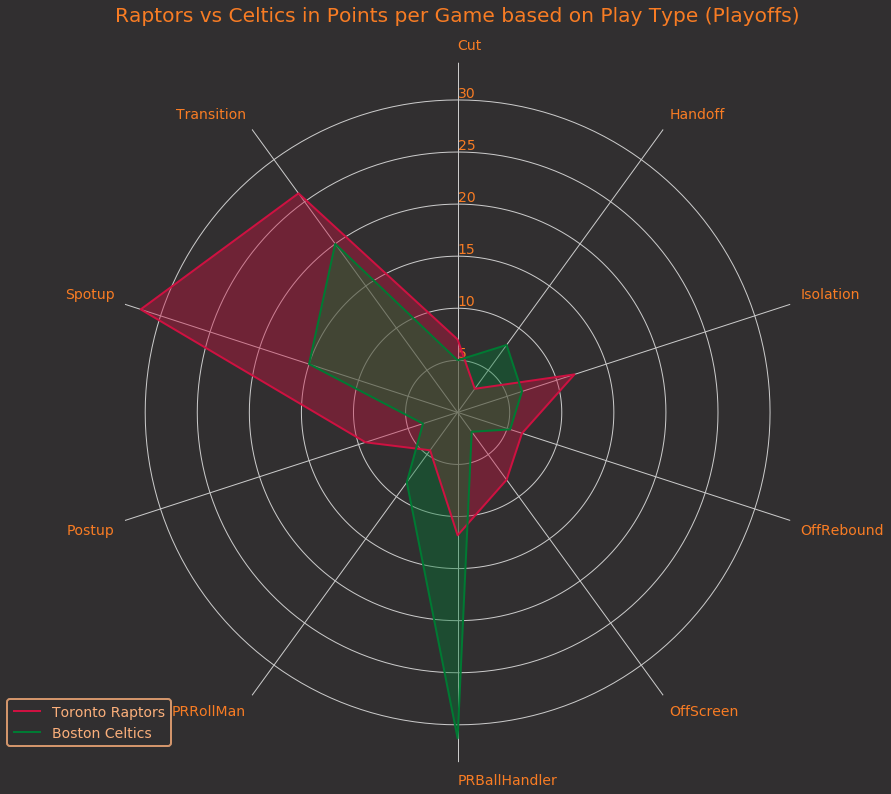

In [72]:
plot_radar(
    first_data=raptors_pt_df,
    first_label='Toronto Raptors',
    first_color='#CE1141',
    second_data=celtics_pt_df,
    second_label='Boston Celtics',
    second_color='#007A33',
    title='Raptors vs Celtics in Points per Game based on Play Type (Playoffs)'
)

#### Regular Season

In [63]:

play_type_dict = {}
for play in play_types:
    synergy = SynergyPlayTypes(player_or_team_abbreviation="T", play_type_nullable=play, type_grouping_nullable="offensive", per_mode_simple="PerGame", season='2019-20')
    synergy_df = synergy.get_data_frames()[0]
    play_type_dict[play] = synergy_df
    time.sleep(1)


In [64]:
raptors_play_type_playoffs = []
celtics_play_type_playoffs = []

for play in play_type_dict:
    cur_df = play_type_dict[play]
    raptors_play_type_playoffs.append(cur_df.loc[cur_df.TEAM_ID == raptors_id])
    celtics_play_type_playoffs.append(cur_df.loc[cur_df.TEAM_ID == celtics_id])
    
raptors_pt_regular_df = pd.concat(raptors_play_type_playoffs).loc[:, ['PLAY_TYPE', 'PTS']].pivot_table(index='PLAY_TYPE', values='PTS').transpose().iloc[0]
celtics_pt_regular_df = pd.concat(celtics_play_type_playoffs).loc[:, ['PLAY_TYPE', 'PTS']].pivot_table(index='PLAY_TYPE', values='PTS').transpose().iloc[0]

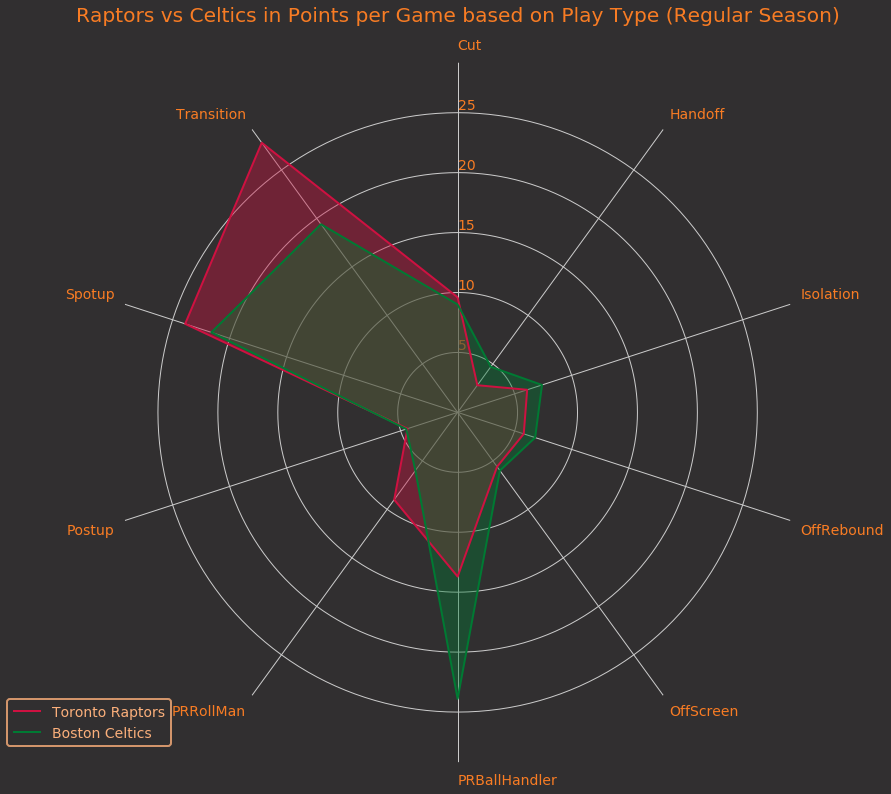

In [65]:
plot_radar(
    first_data=raptors_pt_regular_df,
    first_label='Toronto Raptors',
    first_color='#CE1141',
    second_data=celtics_pt_regular_df,
    second_label='Boston Celtics',
    second_color='#007A33',
    title='Raptors vs Celtics in Points per Game based on Play Type (Regular Season)'
)

#### Raptors only

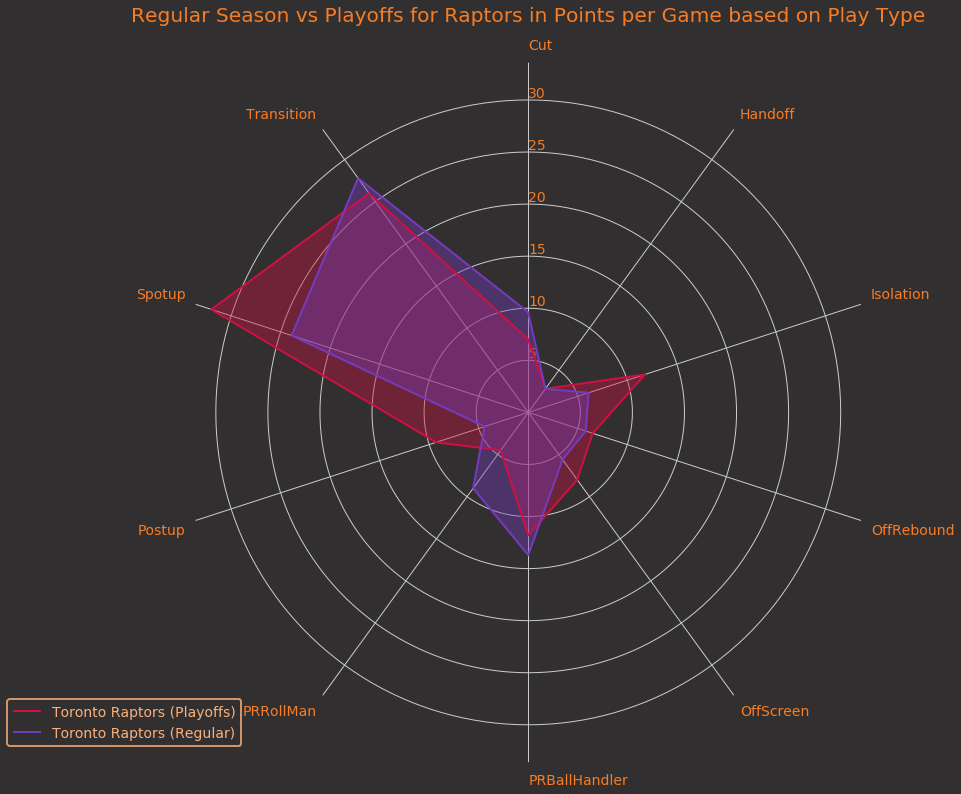

In [66]:
plot_radar(
    first_data=raptors_pt_df,
    first_label='Toronto Raptors (Playoffs)',
    first_color='#CE1141',
    second_data=raptors_pt_regular_df,
    second_label='Toronto Raptors (Regular)',
    second_color='#753BBD',
    title='Regular Season vs Playoffs for Raptors in Points per Game based on Play Type'
)

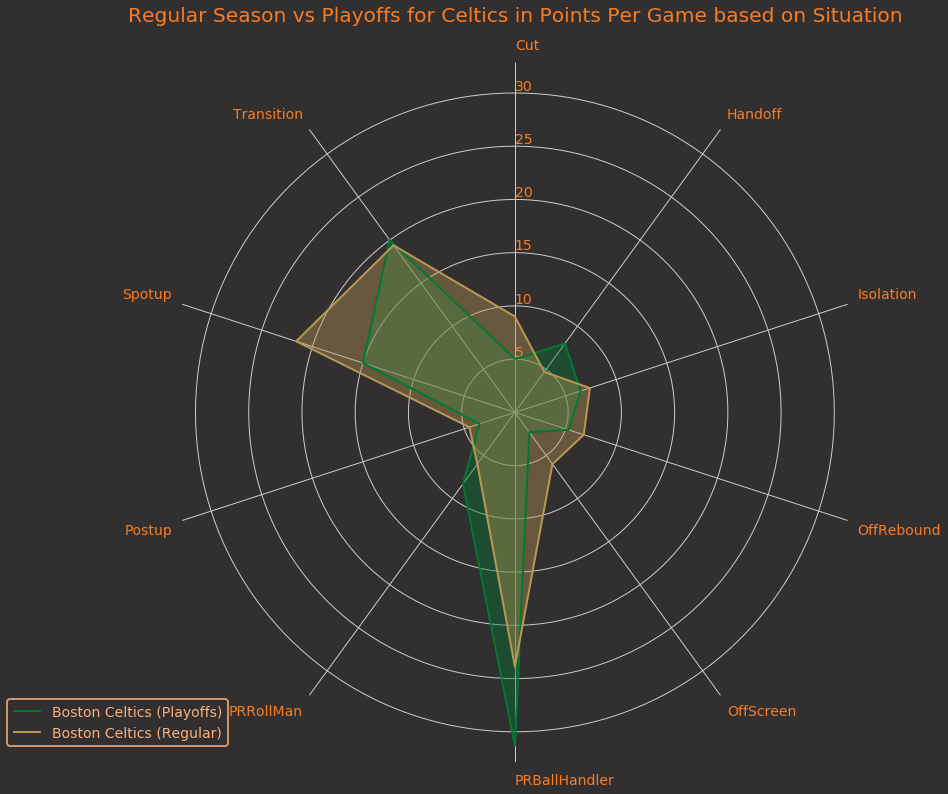

In [67]:
plot_radar(
    first_data=celtics_pt_df,
    first_label='Boston Celtics (Playoffs)',
    first_color='#007A33',
    second_data=celtics_pt_regular_df,
    second_label='Boston Celtics (Regular)',
    second_color='#BA9653',
    title='Regular Season vs Playoffs for Celtics in Points Per Game based on Situation'
)